In [52]:
import matplotlib.pylab as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns
sns.set_style('ticks');
current_colors = sns.color_palette()
sns.set_palette('Accent');
import sys 
sys.path.append('../code_general/')
import Nucleaseq_data_processing as processing
reload(processing)
import read_model_ID as model;
import calculate_cleavage_rate as clv
reload(model);
import sys
sys.path.append('Sequence_dependent_model')
import preprocessing

guide = 20

In [34]:
#----------loading necessary data----------
filename = 'WT_cleavage_rate_and_y0_Canonical_OT-r_0-2.csv'
path_to_data = '../data_nucleaseq_Finkelsteinlab/targetE/'
xdata, ydata, yerr = processing.prepare_multiprocessing_combined('1',filename,'../Data_Boyle/',path_to_data)
_, ydatawa, yerrwa = processing.prepare_multiprocessing_combined('1',filename,'../Data_Boyle/',path_to_data,True,False,False,False)
#_, ydatamedian, yerrmedian = processing.prepare_multiprocessing_nucleaseq(filename, path_to_data, True)
_, ydatalog, yerrlog = processing.prepare_multiprocessing_combined('1',filename,'../Data_Boyle/',path_to_data,True,False,True,False)
_, ydatalogfull, _ = processing.prepare_multiprocessing_combined('1',filename,'../Data_Boyle/',path_to_data,False,False,True,False)


filename_daba = 'cas9-target-e-replicate-1-delta-abas_Canonical_OT-r_0-20.csv'
path_to_data_daba = '../data_ABA_Finkelsteinlab/champ-cas9-cas12a-data/'

filename_aba = 'TargetE-dCas9_AbsoluteABA_Canonical_OT-r_0-2.csv'
path_to_data_aba = '../data_ABA_Finkelsteinlab/champ-cas9-cas12a-data/'

_, ydata_daba, yerr_daba = processing.prepare_multiprocessing_combined_delta_aba(filename_daba,filename,path_to_data_daba,path_to_data,False)
_, ydatawa_daba, yerrwa_daba = processing.prepare_multiprocessing_combined_delta_aba(filename_daba,filename,path_to_data_daba,path_to_data,True)

_, ydata_aba, yerr_aba = processing.prepare_multiprocessing_combined_aba(filename_aba,filename,path_to_data_aba,path_to_data,False)
_, ydatawa_aba, yerrwa_aba = processing.prepare_multiprocessing_combined_aba(filename_aba,filename,path_to_data_aba,path_to_data,True)

datacompclv = []
datacompon = []
datacompaba = []
kclv = []
kon = []
aba = []
errorclv = []
erroron = []
erroraba = []

i = 1
while i < guide+1:
    for a in range(len(xdata)):
        if len(xdata[a])==1 and xdata[a][0]==i:
            kclv.append(ydatawa[a][0][0])
            kon.append(ydatawa[a][1][0])
            aba.append(ydatawa_aba[a][1][0])
            errorclv.append(yerrwa[a][0][0])
            datacompclv.append(ydata[a][0])
            datacompon.append(ydata[a][1])
            datacompaba.append(ydata_aba[a][1])
            erroron.append(yerrwa[a][1][0])
            erroraba.append(yerrwa_aba[a][1][0])

            i = i + 1

kclv.append(ydatawa[0][0][0])
kon.append(ydatawa[0][1][0])
aba.append(ydatawa_aba[0][1][0])
errorclv.append(yerrwa[0][0][0])
erroron.append(yerrwa[0][1][0])
erroraba.append(yerrwa_aba[0][1][0])
datacompclv.append(ydata[0][0])
datacompon.append(ydata[0][1])
datacompaba.append(ydata_aba[0][1])

kclv = np.array(kclv)
kon = np.array(kon)
aba = np.array(aba)
errorclv = np.array(errorclv)
erroron = np.array(erroron)
erroraba = np.array(erroraba)

k_double = np.zeros([20,20])
on_double = np.zeros([20,20])
aba_double = np.zeros([20,20])

for a in range(len(xdata)):
    if len(xdata[a])==2:
        i = xdata[a][0]
        j = xdata[a][1]
        k_double[j-1,i-1] = (ydatalog[a][0][0])
        if len(ydatalog[a][1])==0:
            on_double[j-1,i-1] = np.nan
        else:
            on_double[j-1,i-1] = ydatalog[a][1][0]
        aba_double[j-1,i-1] = ydatawa_aba[a][1][0]

k_double_df = pd.DataFrame(k_double, index=range(1, 21), columns=range(1,21))
on_double_df = pd.DataFrame(on_double, index=range(1,21), columns=range(1,21))
aba_double_df = pd.DataFrame(aba_double, index=range(1,21), columns=range(1,21))

In [29]:
def plot_landscapes_etc(filename,model_ID,parnum,fit_nums,just_clv=False,selection_threshold=1.2,plot_ec=False,plot_ei=True,
                       plot_ls=True,plot_rates=True,plot_block=False):
    simset = []
    final_par = []
    energies = []
    rates = []
    chi_squared = []
    
    #---------- collect simulations ---------------
    for sim in fit_nums:
        sa = pd.read_csv(filename +str(sim)+'.txt', delimiter='\t', index_col=False)
        filename_temp = filename +str(sim) +'.txt'   
        chi_squared.append(sa.Potential.iloc[np.argmin(sa.Potential)])
        simset.append(filename_temp)
        final_par_temp = sa.loc[np.argmin(sa.Potential),'Parameter 1':'Parameter '+parnum]
        final_par_temp = final_par_temp.values
        
        if just_clv: 
            final_par_temp = np.append([2.7],np.append(final_par_temp[0:40],np.append([-2.5],final_par_temp[40:42])))
        #these values for PAM and rate S-P were trained on apparent on-rate data after the model was trained on just cleavage

        model_ID_clv,model_ID_on,parameters_clv,parameters_on = model.combined_model(final_par_temp,model_ID)
        energies_on,rates_on = model.unpack_parameters(parameters_on,model_ID_on,20)
        _,rates_clv = model.unpack_parameters(parameters_clv,model_ID_clv,20)

        energies_on[0] *= -1

        energies.append(energies_on)
        rates.append([np.log10(rates_on[0]),np.log10(rates_on[1]),np.log10(rates_clv[-1])])

        final_par_temp[0] = -final_par_temp[0]
        final_par.append(final_par_temp)

    best_fit = simset[np.argmin(chi_squared)]
    
    
    #--------selecting best simulations-------------
    chi_squared = np.array(chi_squared)
    indices_low_chi = np.where(chi_squared<chi_squared[np.argmin(chi_squared)]*selection_threshold)[0]
    final_par_low_chi = np.array(final_par)[indices_low_chi]
    energies_low_chi = np.array(energies)[indices_low_chi]
    rates_low_chi = np.array(rates)[indices_low_chi]
    low_chi = chi_squared[indices_low_chi]
    
    
    #------------finding median--------------------
    median = np.zeros(len(final_par_low_chi[0]))
    median_energies = np.zeros(len(energies_low_chi[0]))
    median_rates = np.zeros(len(rates_low_chi[0]))

    for i in range(len(final_par_low_chi[0])):
        median_temp = list()
        for j in range(len(final_par_low_chi)):
            median_temp.append(final_par_low_chi[j][i])
        median[i] = np.median(np.array(median_temp))

    for i in range(len(energies_low_chi[0])):
        median_temp = list()
        for j in range(len(energies_low_chi)):
            median_temp.append(energies_low_chi[j][i])
        median_energies[i] = np.median(np.array(median_temp))

    for i in range(len(rates_low_chi[0])):
        median_temp = list()
        for j in range(len(rates_low_chi)):
            median_temp.append(rates_low_chi[j][i])
        median_rates[i] = np.median(np.array(median_temp))
        
    if plot_ls:
        landscapes = np.zeros([len(energies_low_chi),21])
        plt.figure()
        for i in range(len(energies_low_chi)):
            plot1, = plt.plot(range(0,21),-np.cumsum(energies_low_chi[i][0:21]),'y-',label='fit results')
            landscapes[i,:] = -np.cumsum(energies_low_chi[i][0:21])

        medianls = np.median(landscapes, 0)

        plot2, = plt.plot(range(0,21),medianls,'b-o', label='median')    
        plot3, = plt.plot(range(0,21),-np.cumsum(energies[np.argmin(chi_squared)][0:21]),'r-o',label='best fit')

        plt.legend(handles=[plot1,plot2,plot3],fontsize=15)
        plt.xlabel('States',fontsize=15)
        plt.ylabel('Free energy (kBT)',fontsize=15)
        plt.title('Energy landscape',fontsize=15)
        plt.vlines(range(0,21),-10,13,color='grey',linewidth=0.5);
        plt.xticks(range(0,21),['PAM'] + range(1,21),fontsize=15,rotation='vertical');
        plt.yticks(fontsize=15);
        
    if plot_ec:
        plt.figure()
        for i in range(len(energies_low_chi)):
            plot1, = plt.plot(range(0,21),energies_low_chi[i][0:21],'yo',label='fit results')

        plot2, = plt.plot(range(0,21),median_energies[0:21],'bo',label='median')
        plot3, = plt.plot(range(0,21),energies[np.argmin(chi_squared)][0:21],'ro',label='best fit')
        plt.legend(handles=[plot1,plot2,plot3],fontsize=15)
        plt.xlabel('position',fontsize=15)
        plt.ylabel('EpsilonC (kBT)',fontsize=15)
        plt.title('Match energies',fontsize=15)
        plt.vlines(range(0,21),-15,15,color='grey',linewidth=0.5);
        plt.xticks(range(0,21),['-ePAM'] + range(1,21),fontsize=15,rotation='vertical');
        
    if plot_ei:
        plt.figure()
        for i in range(len(energies_low_chi)):
            plot1, = plt.plot(range(1,21),energies_low_chi[i][21:41],'yo',label='fit results')

        plot2, = plt.plot(range(1,21),median_energies[21:41],'bo',label='median')
        plot3, = plt.plot(range(1,21),energies[np.argmin(chi_squared)][21:41],'ro',label='best fit')

        plt.xlabel('position',fontsize=15)
        plt.ylabel('Penalty (kBT)',fontsize=15)
        plt.title('Mismatch Penalties',fontsize=15)
        plt.vlines(range(1,21),0,10,color='grey',linewidth=0.5);
        plt.xticks(range(1,21),range(1,21),fontsize=15,rotation='vertical');
        plt.yticks(fontsize=15);
        
    if plot_rates:
        plt.figure(figsize=[3,4])
        for i in range(len(rates_low_chi)):
            plot1, = plt.plot(range(1,4),rates_low_chi[i],'yo',label='fit results')
            
        plot2, = plt.plot(range(1,4),median_rates,'bo',label='median')
        plot3, = plt.plot(range(1,4),rates[np.argmin(chi_squared)],'ro',label='best fit')
        plt.title('Rates',fontsize=15)
        plt.ylabel('Log$_{10}$ rate (/s)',fontsize=15)
        plt.xticks(range(1,4),['S-P', 'Internal', 'Cleave'],fontsize=15)
        plt.vlines(range(1,4),-3.2,3.2,color='grey',linewidth=0.5);
        plt.yticks(fontsize=15);
        
    if plot_block:
        landscapes = np.zeros([len(energies_low_chi),21])
        plt.figure()
        for i in range(len(energies_low_chi)):
            landscapes[i,:] = -np.cumsum(energies_low_chi[i][0:21])
            
        free_energy = np.zeros([len(landscapes),21])
        for i in range(len(landscapes)):
            sumexp = np.exp(-landscapes[i][0]) #PAM energy
            free_energy[i][0] = -np.log(sumexp)
            for j in range(1,21):
                sumexp = sumexp + np.exp(-landscapes[i][j])
                free_energy[i][j] = -np.log(sumexp)

        for k in range(len(free_energy)):        
            plot1 = plt.plot(range(0,21),free_energy[k],'y-',label='fit results')

        plot3 = plt.plot(range(0,21),np.median(free_energy,0),'b-o',label='median')
        plot2 = plt.plot(range(0,21),free_energy[np.argmin(low_chi)],'r-o',label='best fit')

        plt.ylabel('Bound (macro)state free energy (kBT)',fontsize=15)
        plt.legend(handles=[plot1[0],plot3[0],plot2[0]],loc='center left', bbox_to_anchor=(1, 0.5),fontsize=15)
        plt.xlabel('position',fontsize=15)
        plt.vlines(range(0,21),-10,5,color='grey',linewidth=0.5);
        plt.xticks(range(0,21),['PAM'] + range(1,21),fontsize=15,rotation='vertical');
        plt.yticks(fontsize=15);
    
    return best_fit

In [48]:
def plot_predictions(filename,model_ID,parnum,just_cleave=False,aba_to_on=True,on_to_aba=False,c=4.5):
    
    #----------loading fit------------
    data = pd.read_table(filename,index_col=False)
    chi = data.loc[:,'Potential']
    final_par = data.loc[np.argmin(chi),'Parameter 1':'Parameter '+parnum]
    final_par_np = np.array(final_par.values)
    if just_cleave:
        final_par_np = np.append([2.7],np.append(final_par_np[0:40],np.append([-2.5],final_par_np[40:42])))
    #these values for PAM and rate S-P were trained on apparent on-rate data after the model was trained on just cleavage
        
    final_par_np_on = final_par_np.copy()

    ## aba -> on
    if aba_to_on:
        #c = 4.534
        final_par_np_on[0] = final_par_np_on[0] - np.log(c)
        final_par_np_on[-3] = final_par_np_on[-3] + np.log10(c)

    ## on -> aba
    if on_to_aba:
        #c = 4.553
        final_par_np[0] = final_par_np[0] + np.log(c)
        final_par_np[-3] = final_par_np[-3] - np.log10(c)

    model_ID_clv,model_ID_on,parameters_clv,parameters_on = model.combined_model(final_par_np_on,model_ID)
    model_ID_clv,model_ID_on,parameters_clv,parameters_aba = model.combined_model(final_par_np,model_ID)

    #-----------calculate predictions smm-----------
    legend = False
    f,ax = plt.subplots(3,2,sharey=False,figsize=[12,15])
    k = np.zeros(21)
    on = np.zeros(21)
    abafit = np.zeros(21)
    conc = np.array([0.1, 0.3, 1, 3, 10, 30, 100, 300])

    ref = 10. # in nanomolair
    otaba = clv.calc_ABA(parameters_aba,conc,ref,[],model_ID_on)
    print 'OT-ABA: ' + str(otaba)

    for i in range(1,guide+1):
        mismatch = [i]
        k[i-1],on[i-1] = clv.calc_clv_on(final_par_np_on,model_ID,mismatch,guide)
        _,abafit[i-1] = clv.calc_clv_aba(final_par_np,model_ID,mismatch,guide,conc,ref)

    k[-1],on[-1] = clv.calc_clv_on(final_par_np_on,model_ID,[],guide)
    abafit[-1] = 0.
    abafit[-1] = otaba

    #-----------plot smm--------------
    for i in range(21):
        #print len(datacompclv[i])
        plot1 = ax[0][0].plot((i+1)*np.ones(len(datacompclv[i])),datacompclv[i],marker='x',color='coral',linewidth=0,label='Experimental data')
    plot2 = ax[0][0].plot(range(1,21),kclv[0:20],marker='o',color='r',label='Weighted average\n(mutants)')
    ax[0][0].errorbar(range(1,21),kclv[0:20],yerr=errorclv[0:20],color='r',capsize=5)
    plot3 = ax[0][0].plot(21,kclv[20],marker='x',color='r',markersize=15,label='Weighted average\n(on-target)')
    plot4 = ax[0][0].plot(range(1,22),np.log10(k),color='b',marker='o',label='Prediction')
    if legend:
        ax[0][0].legend(handles=[plot1[0],plot2[0],plot3[0],plot4[0]],loc='center left',bbox_to_anchor=(1,0.5),fontsize=15)
    ax[0][0].set_xlabel('single mismatch position', fontsize=15)
    ax[0][0].set_ylabel('Log$_{10}$ cleavage rate (Hz)', fontsize=15)
    ax[0][0].set_title('Cleavage rate for single mismatch, prediction', fontsize=15)
    ax[0][0].set_xticks(range(1,22));
    ax[0][0].set_xticklabels(range(1,21)+['OT'],fontsize=15)
    ax[0][0].vlines(range(1,22),-6,1,color='grey',linewidth=0.5);

    for i in range(21):
        plot1 = ax[2][0].plot((i+1)*np.ones(len(datacompon[i])),datacompon[i],marker='x',color='coral',linewidth=0,label='Experimental data')
    plot2 = ax[2][0].plot(range(1,21),kon[0:20],marker='o',color='r',label='Weighted average')
    plot3 = ax[2][0].plot(21,kon[20],marker='x',color='r',markersize=15,label='On-target')
    plot4 = ax[2][0].semilogy(range(1,22),on,marker='o',linewidth=1,color='blue',label='Prediction')
    ax[2][0].errorbar(range(1,21),kon[0:20],yerr=erroron[0:20],color='r',capsize=5)
    if legend:
        ax[2][0].legend(handles=[plot1[0],plot2[0],plot3[0],plot4[0]],loc='center left',bbox_to_anchor=(1,0.5),fontsize=15)
    ax[2][0].set_xlabel('single mismatch position', fontsize=15)
    ax[2][0].set_ylabel('Apparent on-rate (Hz)', fontsize=15)
    ax[2][0].set_title('Apparent on-rate for single mismatch, prediction', fontsize=15)
    ax[2][0].set_xticks(range(1,22));
    ax[2][0].set_xticklabels(range(1,21)+['OT'],fontsize=15)
    ax[2][0].vlines(range(1,22),10**-5.,10**-3.,color='grey',linewidth=0.5);

    for i in range(21):
        plot1, = ax[1][0].plot((i+1)*np.ones(len(datacompaba[i])),datacompaba[i],marker='x',color='coral',linewidth=0,label='Experimental \ndata')
    plot2, = ax[1][0].plot(range(1,21),aba[:-1],marker='o',color='r',label='Weighted \naverage')
    plot3, = ax[1][0].plot(21,aba[-1],marker='x',color='r',markersize=15,label='On-target')
    plot4, = ax[1][0].plot(range(1,22),abafit,marker='o',color='b',label='Prediction')
    if legend:
        ax[1][0].legend(handles=[plot1,plot2,plot3,plot4],fontsize=15,loc='center left',bbox_to_anchor=(1,0.5))
    ax[1][0].set_xlabel('single mismatch position', fontsize=15)
    ax[1][0].set_ylabel('ABA (kBT)', fontsize=15)
    ax[1][0].set_title('ABA for single mismatch, prediction', fontsize=15)
    ax[1][0].set_xticks(range(1,22));
    ax[1][0].set_xticklabels(range(1,21)+['OT'],fontsize=15)
    ax[1][0].vlines(range(1,22),2.,5.5,color='grey',linewidth=0.5);
    
    
    #-------------calculate predictions dmm----------
    k_matrix = np.zeros([20,20])
    on_matrix = np.zeros([20,20])
    aba_matrix = np.zeros([20,20])

    for i in range(1,20):
        for j in range(i+1,21):
            mismatch_positions = [i,j]
            k_matrix[i-1,j-1], on_matrix[i-1,j-1] = np.log10(clv.calc_clv_on(final_par_np_on,model_ID,mismatch_positions,guide))
            _, aba_matrix[i-1,j-1] = clv.calc_clv_aba(final_par_np,model_ID,mismatch_positions,guide,conc,ref)


    k_df = pd.DataFrame(k_matrix, index=range(1, 21), columns=range(1, 21))
    on_df = pd.DataFrame(on_matrix, index=range(1,21), columns=range(1,21))
    aba_df = pd.DataFrame(aba_matrix, index=range(1,21), columns=range(1,21))

    combined_df_wa = k_df + k_double_df
    combined_on = on_df + on_double_df
    combined_aba = aba_df + aba_double_df

    for i in range(1,21):
        combined_df_wa[i].loc[i]= np.nan
        combined_on[i].loc[i] = np.nan
        combined_aba[i].loc[i] = np.nan

    sns.heatmap(combined_df_wa, cmap='coolwarm', cbar=True,ax=ax[0][1], vmin=-5, vmax = -1)
    ax[0][1].set_xlabel('mismatch 1', fontsize=15)
    ax[0][1].set_ylabel('mismatch 2', fontsize=15)
    ax[0][1].set_title('Cleavage rate, double mismatches \ntop=model bottom=experiment', fontsize=15)

    sns.heatmap(combined_on,cmap='coolwarm', cbar=True,ax=ax[2][1], vmin = -5, vmax = -3.5)
    ax[2][1].set_xlabel('mismatch 1', fontsize=15)
    ax[2][1].set_ylabel('mismatch 2', fontsize=15)
    ax[2][1].set_title('Apparent on-rate, double mismatches \ntop=model bottom=experiment', fontsize=15)

    sns.heatmap(combined_aba,cmap='coolwarm', cbar=True,ax=ax[1][1], vmin = 1.5, vmax = 5.5)
    ax[1][1].set_xlabel('mismatch 1', fontsize=15)
    ax[1][1].set_ylabel('mismatch 2', fontsize=15)
    ax[1][1].set_title('\nABA, double mismatches \ntop=model bottom=experiment', fontsize=15)

    plt.tight_layout()

In [59]:
def plot_corr(filename,model_ID,parnum,just_cleave=False,aba_to_on=True,on_to_aba=False,c=4.5):
    #-----------load in seq dep data------------
    path = '../data_nucleaseq_Finkelsteinlab/targetE/'
    xdata_all,ydata_all_wa,yerr_all_wa = preprocessing.prepare_multiprocessing_seq_dep_wa('WT_cleavage_rate_and_y0_Canonical_OT-r_0-2_target.csv',path)

    path = '../data_ABA_Finkelsteinlab/champ-cas9-cas12a-data/'
    file2 = 'TargetE-dCas9_AbsoluteABA_Canonical_OT-r_0-2_target.csv'
    xdata_all_aba,ydata_all_wa_aba,yerr_all_wa_aba = preprocessing.prepare_multiprocessing_seq_dep_wa_aba(file2,path)


    smm_data_clv = []
    dmm_data_clv = []
    smm_fit_clv = []
    dmm_fit_clv = []
    smm_ref_clv = []
    dmm_ref_clv = []

    smm_data_aba = []
    dmm_data_aba = []
    smm_fit_aba = []
    dmm_fit_aba = []
    smm_ref_aba = []
    dmm_ref_aba = []

    smm_data_on = []
    dmm_data_on = []
    smm_fit_on = []
    dmm_fit_on = []
    smm_ref_on = []
    dmm_ref_on = []
    
    #----------loading fit------------
    data = pd.read_table(filename,index_col=False)
    chi = data.loc[:,'Potential']
    final_par = data.loc[np.argmin(chi),'Parameter 1':'Parameter '+parnum]
    final_par_np = np.array(final_par.values)
    if just_cleave:
        final_par_np = np.append([2.7],np.append(final_par_np[0:40],np.append([-2.5],final_par_np[40:42])))
    #these values for PAM and rate S-P were trained on apparent on-rate data after the model was trained on just cleavage
        
    final_par_np_on = final_par_np.copy()

    ## aba -> on
    if aba_to_on:
        #c = 4.534
        final_par_np_on[0] = final_par_np_on[0] - np.log(c)
        final_par_np_on[-3] = final_par_np_on[-3] + np.log10(c)

    ## on -> aba
    if on_to_aba:
        #c = 4.553
        final_par_np[0] = final_par_np[0] + np.log(c)
        final_par_np[-3] = final_par_np[-3] - np.log10(c)

    model_ID_clv,model_ID_on,parameters_clv,parameters_on = model.combined_model(final_par_np_on,model_ID)
    model_ID_clv,model_ID_on,parameters_clv,parameters_aba = model.combined_model(final_par_np,model_ID)
    
    #------------calculate predictions------------
    conc = np.array([0.1, 0.3, 1, 3, 10, 30, 100, 300])
    ref = 10. # in nanomolair
    for i in range(len(xdata_all)):
        if len(xdata_all[i][2])<2:
            clv_temp = np.log10(clv.calc_clv_rate_fast(parameters_clv,model_ID_clv,xdata_all[i][2],20))
            for j in range(len(ydata_all_wa[i])):
                if  ydata_all_wa[i][j]>-5 and ydata_all_wa[i][j]<0:
                    smm_data_clv.append(ydata_all_wa[i][j])
                    smm_fit_clv.append(clv_temp)
                    if len(xdata_all[i][2])>0:
                        smm_ref_clv.append(kclv[xdata_all[i][2][0]-1])
                    else:
                        smm_ref_clv.append(kclv[-1])
        if len(xdata_all[i][2])==2:
            clv_temp = np.log10(clv.calc_clv_rate_fast(parameters_clv,model_ID_clv,xdata_all[i][2],20))
            for j in range(len(ydata_all_wa[i])):
                if  ydata_all_wa[i][j]>-5 and ydata_all_wa[i][j]<0:
                    dmm_data_clv.append(ydata_all_wa[i][j])
                    dmm_fit_clv.append(clv_temp)
                    dmm_ref_clv.append(k_double[xdata_all[i][2][1]-1,xdata_all[i][2][0]-1])

    smm_corr_ref_clv = np.corrcoef([smm_data_clv,smm_ref_clv])[0][1]
    dmm_corr_ref_clv = np.corrcoef([dmm_data_clv,dmm_ref_clv])[0][1]
    print 'Reference correlations (correlation of seq indep weighted average of data): '
    print smm_corr_ref_clv
    print dmm_corr_ref_clv


    for i in range(len(xdata_all_aba)):
        if len(xdata_all_aba[i][2])<2:
            aba_temp = clv.calc_ABA(parameters_aba,conc,ref,xdata_all_aba[i][2],model_ID_on)
            for j in range(len(ydata_all_wa_aba[i])):
                smm_data_aba.append(ydata_all_wa_aba[i][j])
                smm_fit_aba.append(aba_temp)
                if len(xdata_all_aba[i][2])>0:
                    smm_ref_aba.append(aba[xdata_all_aba[i][2][0]-1])
                else:
                    smm_ref_aba.append(aba[-1])
        if len(xdata_all_aba[i][2])==2:
            aba_temp = clv.calc_ABA(parameters_aba,conc,ref,xdata_all_aba[i][2],model_ID_on)
            for j in range(len(ydata_all_wa_aba[i])):
                dmm_data_aba.append(ydata_all_wa_aba[i][j])
                dmm_fit_aba.append(aba_temp)
                dmm_ref_aba.append(aba_double[xdata_all_aba[i][2][1]-1,xdata_all_aba[i][2][0]-1])

    smm_corr_ref_aba = np.corrcoef([smm_data_aba,smm_ref_aba])[0][1]
    dmm_corr_ref_aba = np.corrcoef([dmm_data_aba,dmm_ref_aba])[0][1]
    print smm_corr_ref_aba
    print dmm_corr_ref_aba

    for i in range(len(xdata)):
        if len(xdata[i])<2:
            _,on_temp = clv.calc_clv_on(final_par_np_on,model_ID,xdata[i],20)
            on_temp = np.log10(on_temp)
            for j in range(len(ydatalogfull[i][1])):
                smm_data_on.append(ydatalogfull[i][1][j])
                smm_fit_on.append(on_temp)
                if len(xdata[i])>0:
                    smm_ref_on.append(np.log10(kon[xdata[i][0]-1]))
                else:
                    smm_ref_on.append(np.log10(kon[-1]))
        if len(xdata[i])==2:
            _,on_temp = clv.calc_clv_on(final_par_np_on,model_ID,xdata[i],20)
            on_temp = np.log10(on_temp)
            for j in range(len(ydatalogfull[i][1])):
                dmm_data_on.append(ydatalogfull[i][1][j])
                dmm_fit_on.append(on_temp)
                dmm_ref_on.append(on_double[xdata[i][1]-1,xdata[i][0]-1])

    smm_corr_ref_on = np.corrcoef([smm_data_on,smm_ref_on])[0][1]
    dmm_corr_ref_on = np.corrcoef([dmm_data_on,dmm_ref_on])[0][1]
    print smm_corr_ref_on
    print dmm_corr_ref_on

    #-----------make correlation plots------------
    f,ax = plt.subplots(2,3,sharey=False,figsize=[15,9])
    plt1, = ax[0][0].plot(smm_fit_clv,smm_data_clv,marker='o',markersize=10,color='lime',linewidth=0.0, label='smm')
    plt2, = ax[1][0].plot(dmm_fit_clv,dmm_data_clv,marker='o',markersize=10,color='green',linewidth=0.0, label='dmm')
    ax[0][0].plot([-7,0.5],[-7,0.5],'k-.',linewidth=3)
    ax[0][0].axis([-7,0.5,-7,0.5])
    ax[1][0].plot([-7,0.5],[-7,0.5],'k-.',linewidth=3)
    ax[1][0].axis([-7,0.5,-7,0.5])
    ax[0][0].set_title('Norm. Loglog corr. coef.: ' + str(np.round(np.corrcoef([smm_data_clv,smm_fit_clv])[0][1]/smm_corr_ref_clv,4)), fontsize=20)
    ax[1][0].set_title('Norm. Loglog corr. coef.: '+ str(np.round(np.corrcoef([dmm_data_clv,dmm_fit_clv])[0][1]/dmm_corr_ref_clv,4)), fontsize=20)
    ax[1][0].set_xlabel('Predicted log$_{10}$ cleavage rate (Hz)',fontsize=15)
    ax[1][0].set_ylabel('Measured log$_{10}$ cleavage rate (Hz)',fontsize=15)
    ax[0][0].set_ylabel('Measured log$_{10}$ cleavage rate (Hz)',fontsize=15)

    plt1, = ax[0][1].plot(smm_fit_aba,smm_data_aba,marker='o',markersize=10,color='c',linewidth=0.0, label='smm')
    plt2, = ax[1][1].plot(dmm_fit_aba,dmm_data_aba,marker='o',markersize=10,color='b',linewidth=0.0, label='dmm')
    ax[0][1].plot([2.,6.],[2.,6.],'k-.',linewidth=3)
    ax[0][1].axis([2.,6.,2.,6.])
    ax[1][1].plot([2.,6.],[2.,6.],'k-.',linewidth=3)
    ax[1][1].axis([2.,6.,2.,6.])
    ax[0][1].set_title('Norm. Corr. coef.: ' + str(np.round(np.corrcoef([smm_data_aba,smm_fit_aba])[0][1]/smm_corr_ref_aba,4)), fontsize=20)
    ax[1][1].set_title('Norm. Corr. coef.: '+ str(np.round(np.corrcoef([dmm_data_aba,dmm_fit_aba])[0][1]/dmm_corr_ref_aba,4)), fontsize=20)
    ax[1][1].set_xlabel('Predicted ABA',fontsize=15)
    ax[1][1].set_ylabel('Measured ABA',fontsize=15)
    ax[0][1].set_ylabel('Measured ABA',fontsize=15)

    plt1, = ax[0][2].plot(smm_fit_on,smm_data_on,marker='o',markersize=10,color='coral',linewidth=0.0, label='smm')
    plt2, = ax[1][2].plot(dmm_fit_on,dmm_data_on,marker='o',markersize=10,color='red',linewidth=0.0, label='dmm')
    ax[0][2].plot([-5.,-3.],[-5.,-3.],'k-.',linewidth=3)
    ax[0][2].axis([-5.,-3.,-5.,-3.])
    ax[1][2].plot([-5.,-3.],[-5.,-3.],'k-.',linewidth=3)
    ax[1][2].axis([-5.,-3.,-5.,-3.])
    ax[0][2].set_title('Norm. Loglog corr. coef.: ' + str(np.round(np.corrcoef([smm_data_on,smm_fit_on])[0][1]/smm_corr_ref_on,4)), fontsize=20)
    ax[1][2].set_title('Norm. Loglog corr. coef.: '+ str(np.round(np.corrcoef([dmm_data_on,dmm_fit_on])[0][1]/dmm_corr_ref_on,4)), fontsize=20)
    ax[1][2].set_xlabel('Predicted log$_{10}$ app. on-rate (Hz)',fontsize=15)
    ax[1][2].set_ylabel('Measured log$_{10}$ app. on-rate (Hz)',fontsize=15)
    ax[0][2].set_ylabel('Measured log$_{10}$ app. on-rate (Hz)',fontsize=15)


    #plt.legend(handles=[plt1,plt2],fontsize=17)
    plt.tight_layout()

## Fitted to just cleavage (10-8-2019) (section 5.1)

Best fit:  ../fits_Stijn/10_8_2019/fit_10_8_2019_sim_12.txt
OT-ABA: 2.693306024662269
Reference correlations (correlation of seq indep weighted average of data): 
0.8668060830705444
0.800834156959948
0.9413836241183235
0.9637182618586885
0.9493699963875727
0.9355032259989193


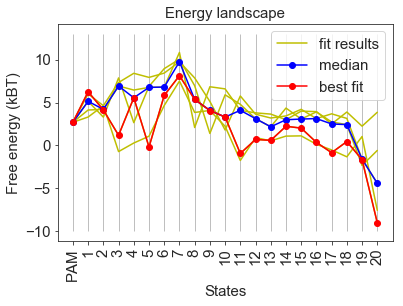

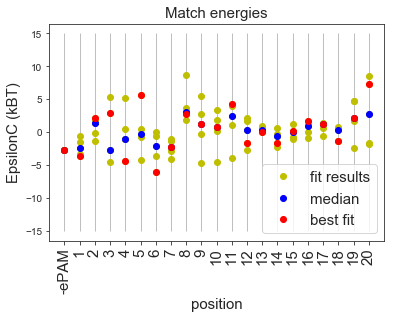

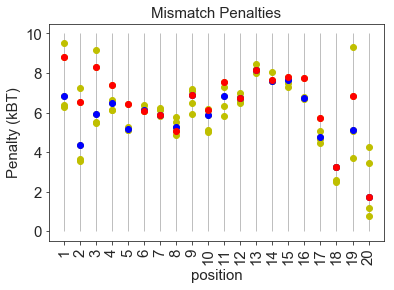

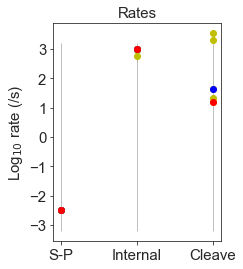

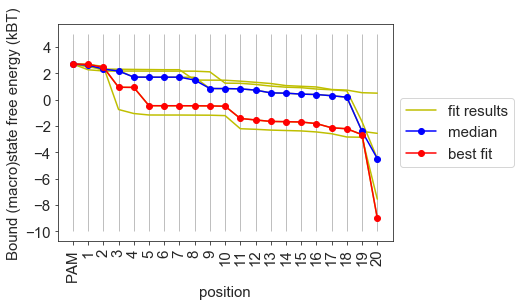

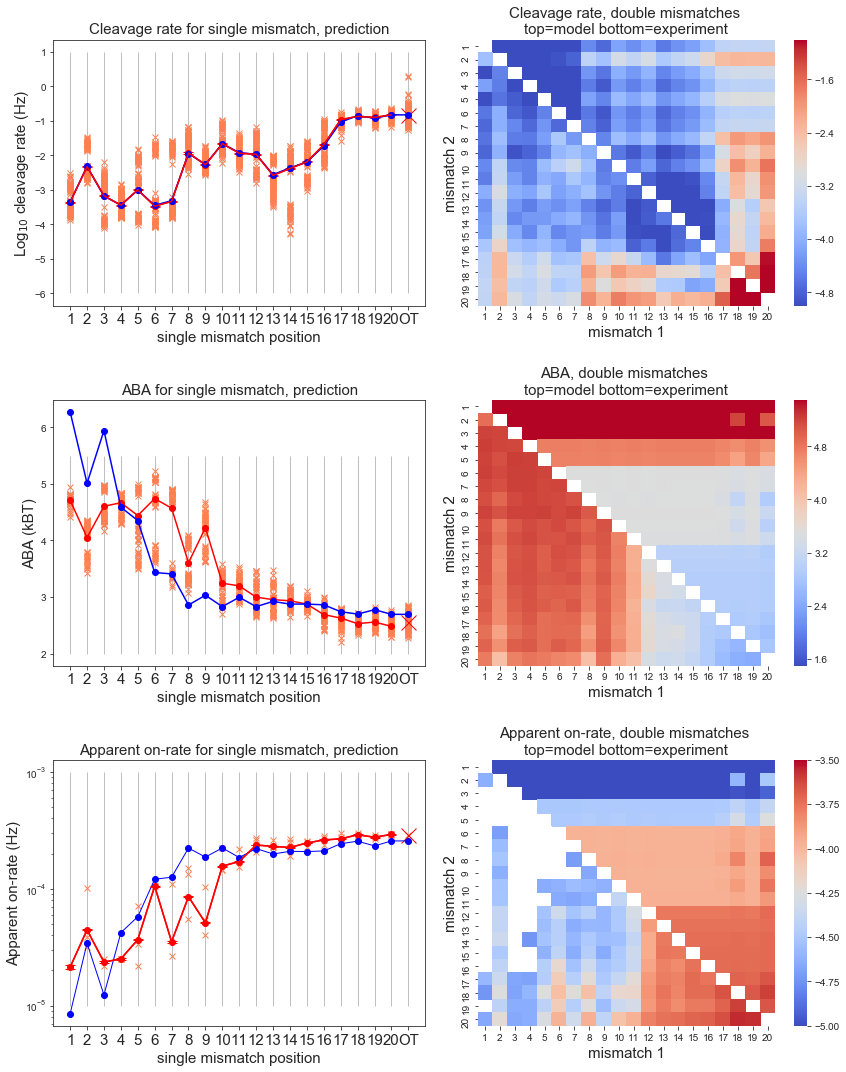

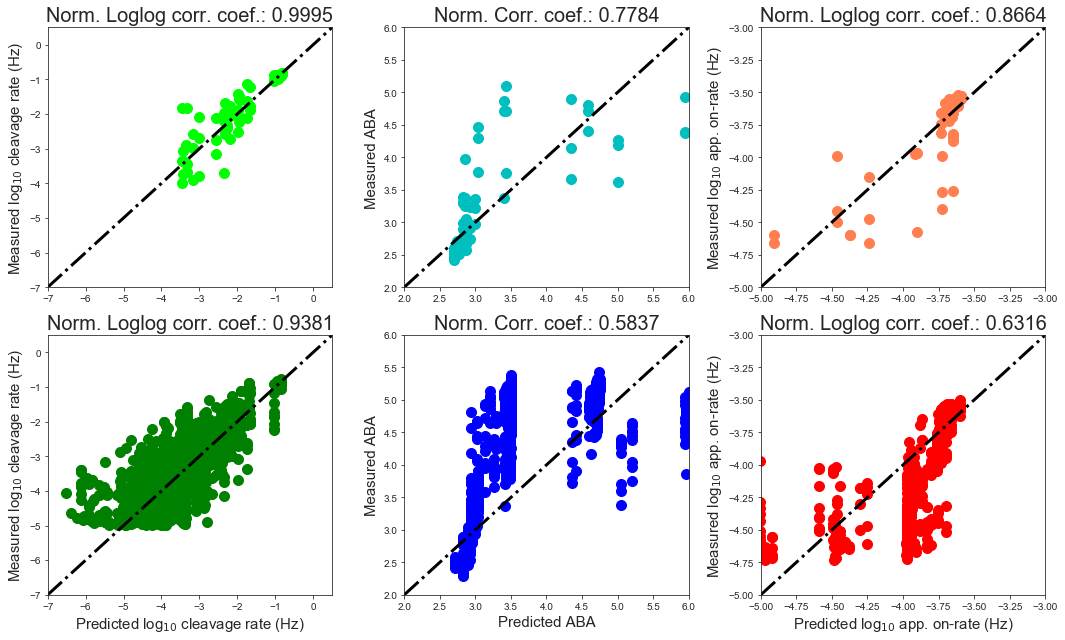

In [60]:
filename = '../fits_Stijn/10_8_2019/fit_10_8_2019_sim_'
model_ID = 'Clv_Saturated_general_energies_v2+general_energies_no_kPR'
parnum = '42'
fit_nums = range(1,26)
just_clv=True

best_fit = plot_landscapes_etc(filename,model_ID,parnum,fit_nums,just_clv,plot_ec=True,plot_block=True)

print 'Best fit: ', best_fit

plot_predictions(best_fit,model_ID,parnum,just_clv,aba_to_on=False,on_to_aba=True)
plot_corr(best_fit,model_ID,parnum,just_clv,aba_to_on=False,on_to_aba=True)

## Fitted to combined NucleaSeq and CHAMP (18-7-2019) (section 5.2)

Best fit:  ../fits_Stijn/18_7_2019/fit_18_7_2019_sim_17.txt
OT-ABA: 2.5524129077173976
Reference correlations (correlation of seq indep weighted average of data): 
0.8668060830705444
0.800834156959948
0.9413836241183235
0.9637182618586885
0.9493699963875727
0.9355032259989193


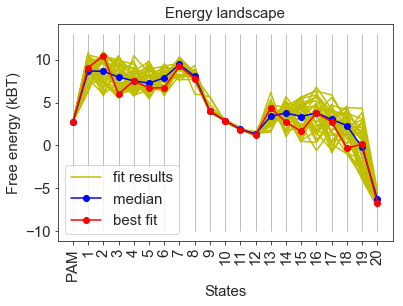

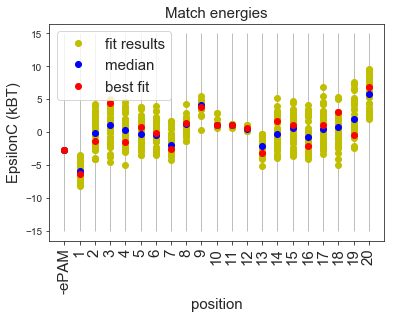

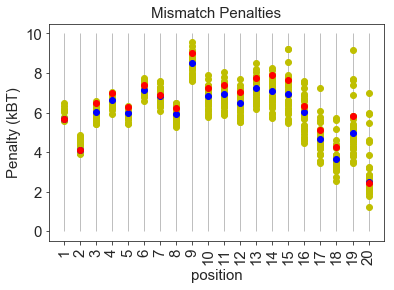

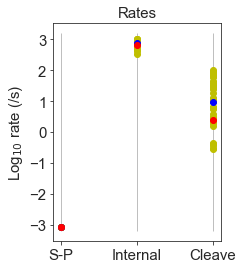

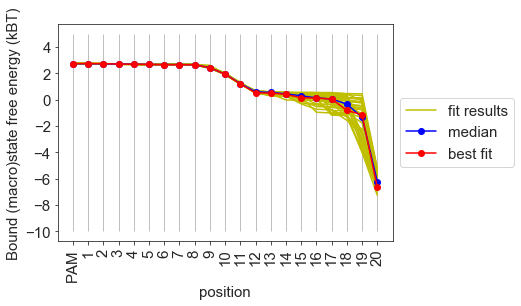

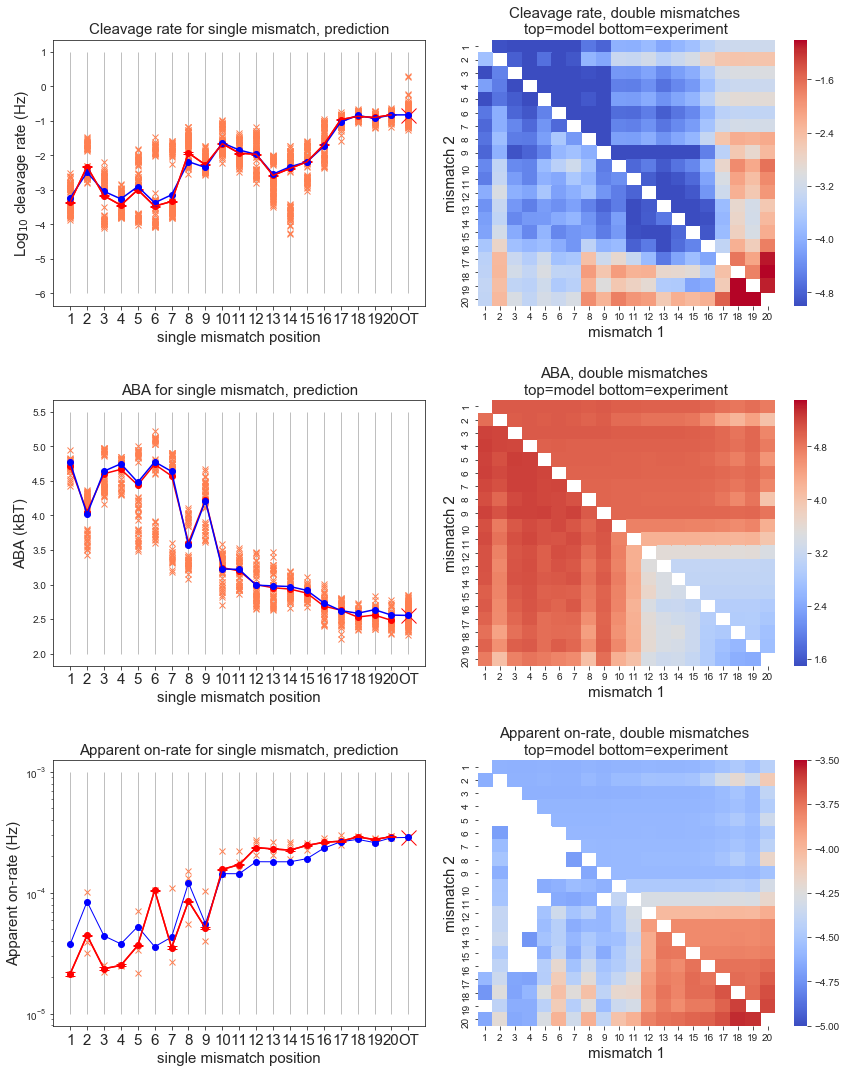

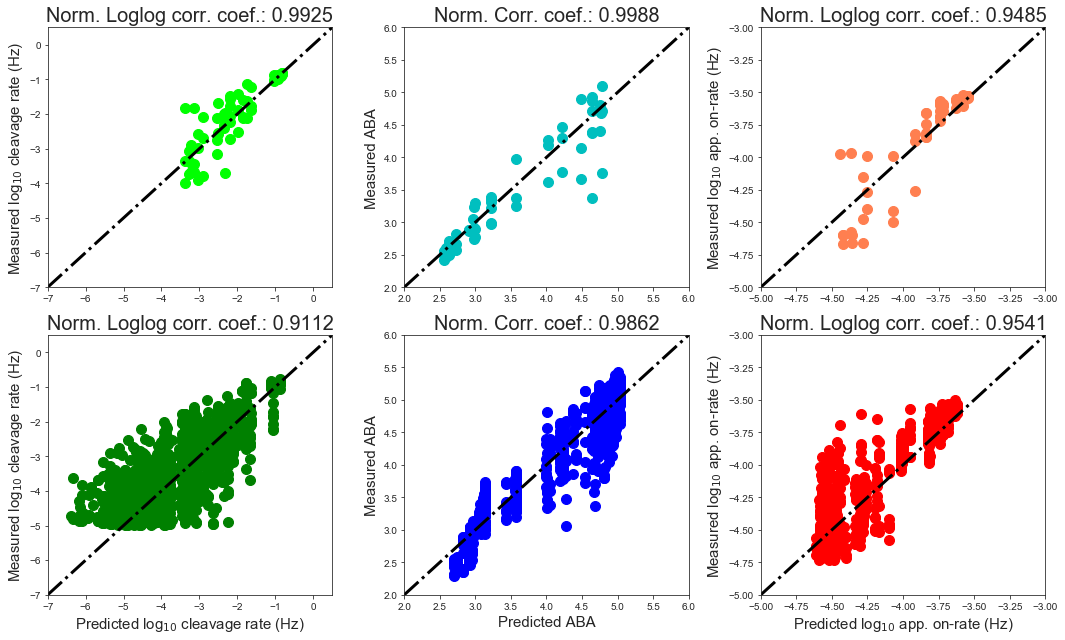

In [62]:
filename = '../fits_Stijn/18_7_2019/fit_18_7_2019_sim_'
model_ID = 'Clv_Saturated_general_energies_v2+general_energies_no_kPR'
parnum = '44'
fit_nums = range(1,51)
just_clv=False

best_fit = plot_landscapes_etc(filename,model_ID,parnum,fit_nums,just_clv,plot_ec=True,plot_block=True)

print 'Best fit: ', best_fit

plot_predictions(best_fit,model_ID,parnum,just_clv,aba_to_on=True,on_to_aba=False)
plot_corr(best_fit,model_ID,parnum,just_clv,aba_to_on=True,on_to_aba=False)

## Fitted to combined NucleaSeq and Boyle (13-6-2019) (supplemental info)

Best fit:  ../fits_Stijn/13_6_2019/fit_13_6_2019_sim_40.txt
OT-ABA: 2.5431036888173524
Reference correlations (correlation of seq indep weighted average of data): 
0.8668060830705444
0.800834156959948
0.9413836241183235
0.9637182618586885
0.9493699963875727
0.9355032259989193


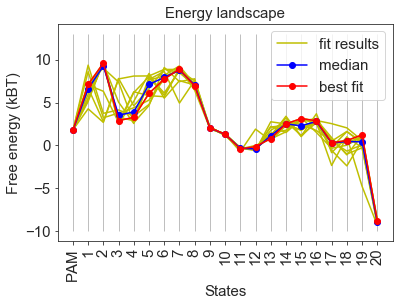

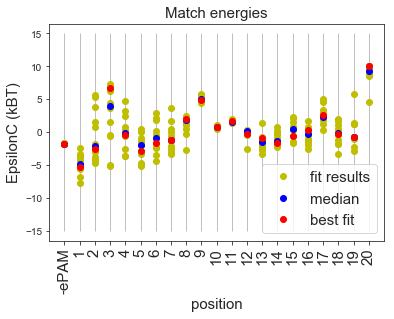

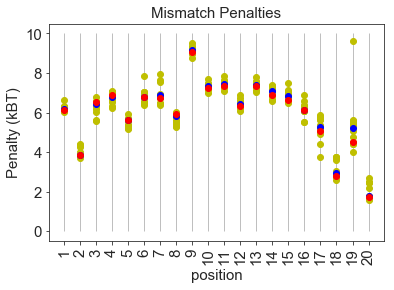

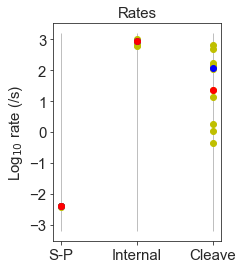

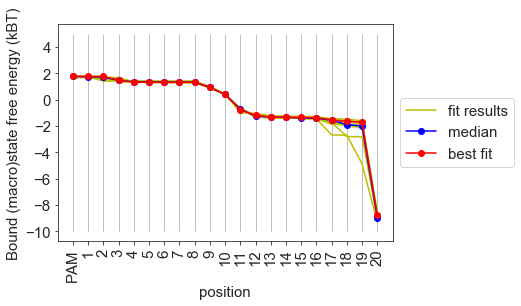

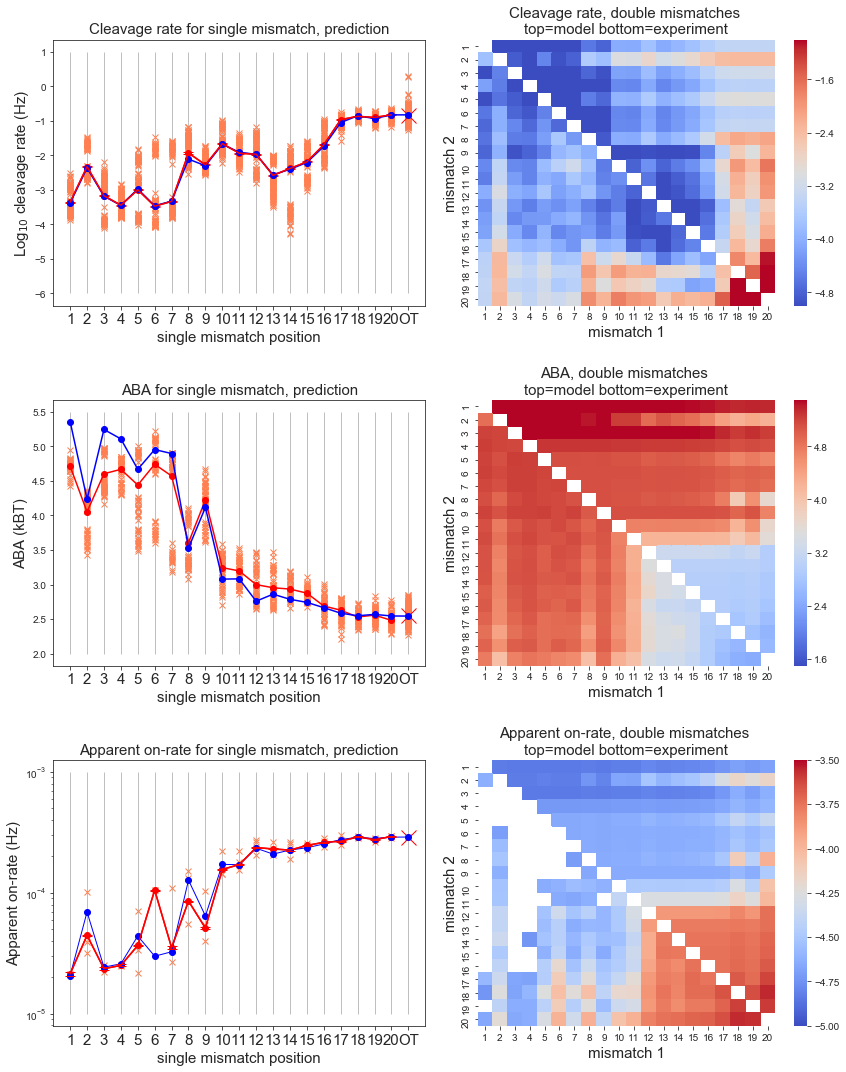

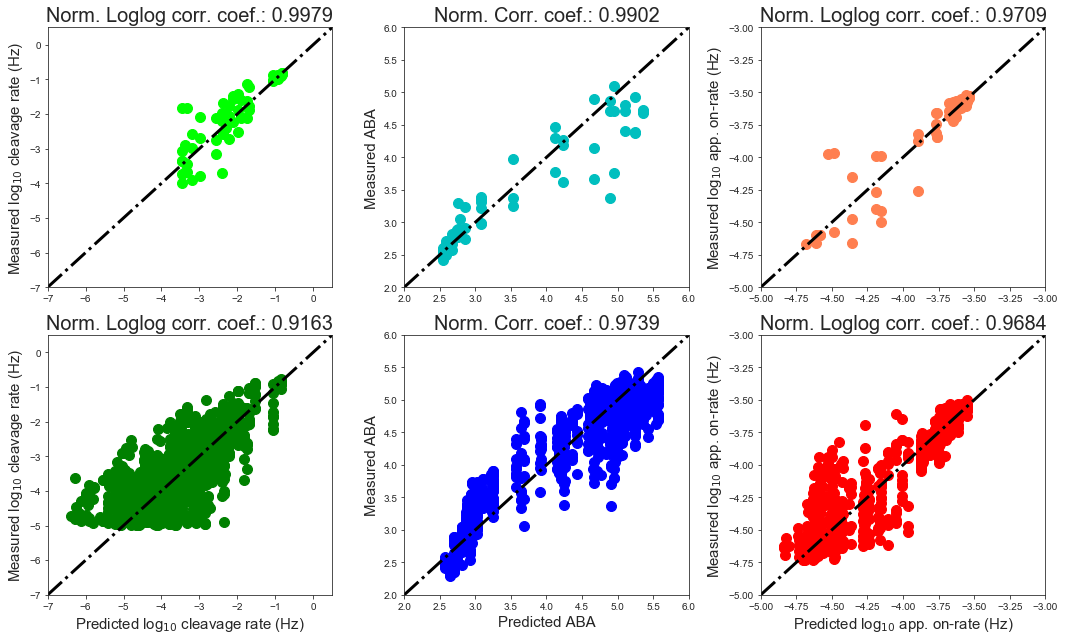

In [61]:
filename = '../fits_Stijn/13_6_2019/fit_13_6_2019_sim_'
model_ID = 'Clv_Saturated_general_energies_v2+general_energies_no_kPR'
parnum = '44'
fit_nums = range(1,51)
just_clv=False

best_fit = plot_landscapes_etc(filename,model_ID,parnum,fit_nums,just_clv,plot_ec=True,plot_block=True)

print 'Best fit: ', best_fit

plot_predictions(best_fit,model_ID,parnum,just_clv,aba_to_on=False,on_to_aba=True)
plot_corr(best_fit,model_ID,parnum,just_clv,aba_to_on=False,on_to_aba=True)

## For coarse graining stuff, see coarse_graining.ipynb (section 5.4)

## Barrier scaling, see also scaling_bumps.ipynb and coarse_graining.ipynb (section 5.5)

Best fit:  ../fits_Stijn/8_8_2019/fit_8_8_2019_sim_4.txt
OT-ABA: 2.552227089631445
Reference correlations (correlation of seq indep weighted average of data): 
0.8668060830705444
0.800834156959948
0.9413836241183235
0.9637182618586885
0.9493699963875727
0.9355032259989193


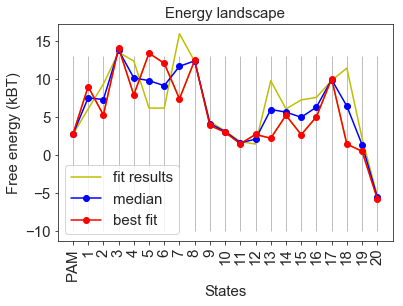

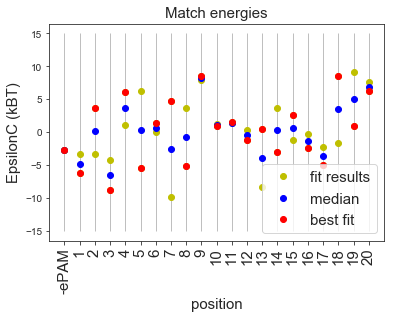

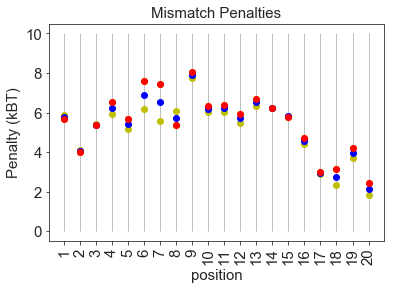

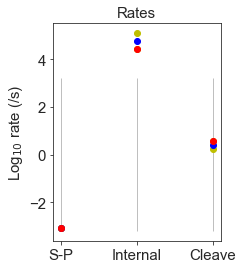

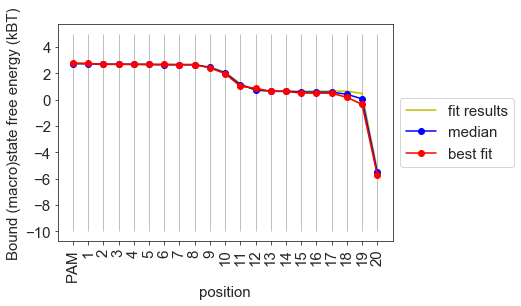

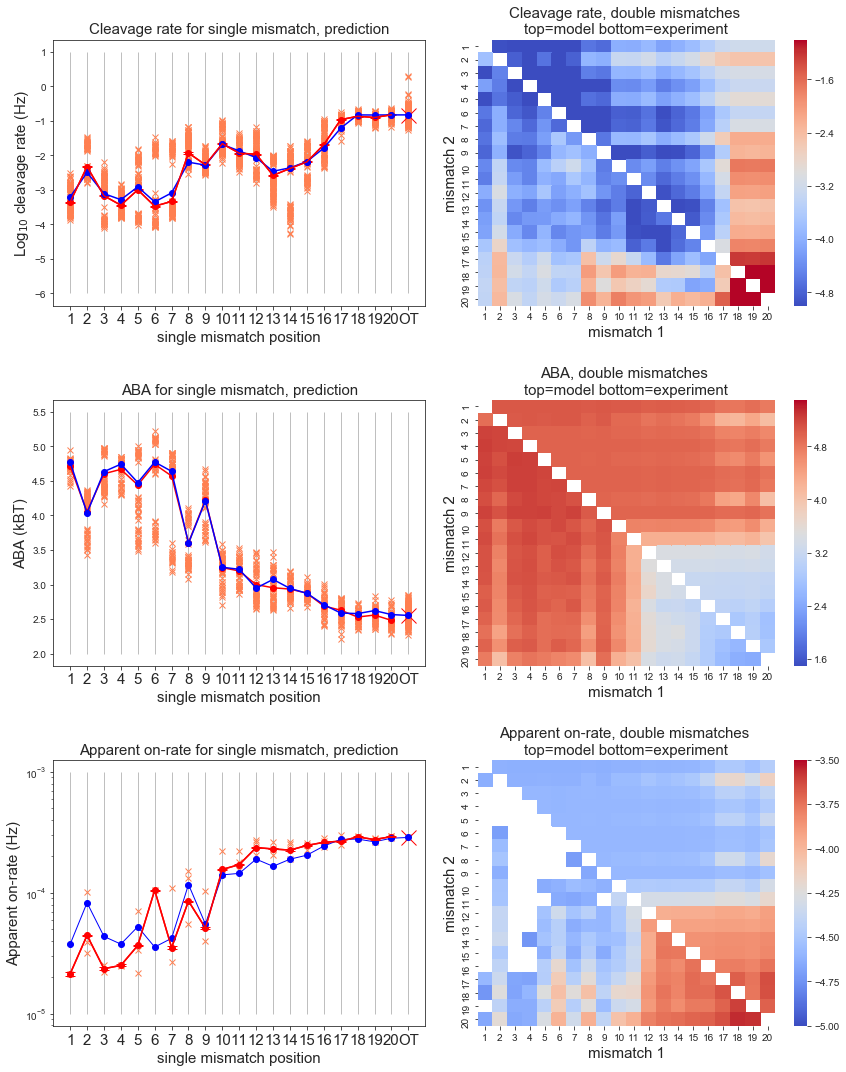

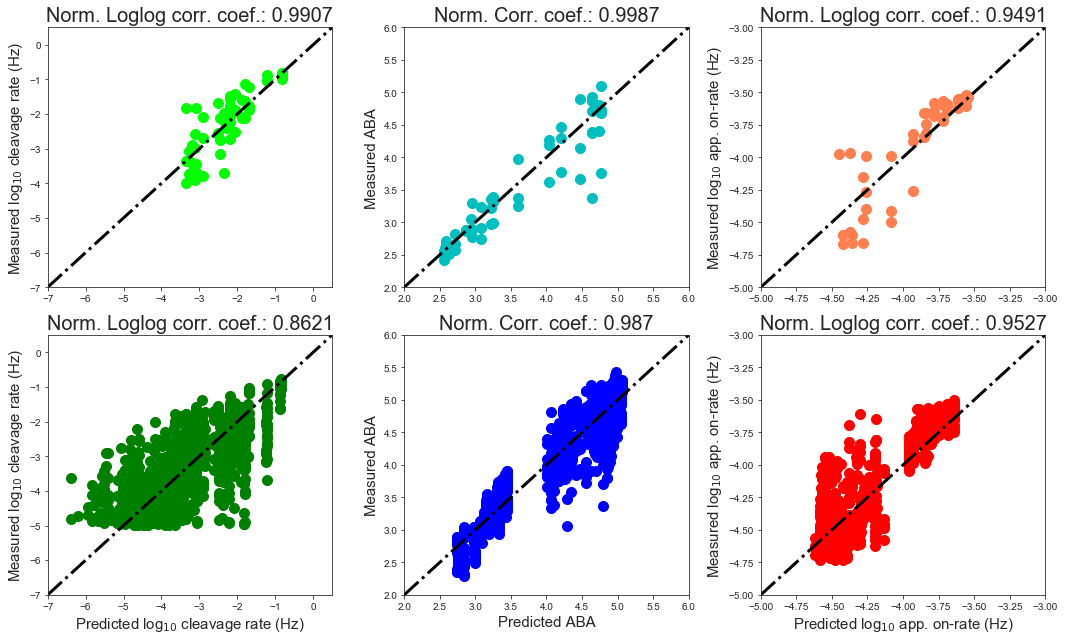

In [64]:
filename = '../fits_Stijn/8_8_2019/fit_8_8_2019_sim_'
model_ID = 'Clv_Saturated_general_energies_v2+general_energies_no_kPR'
parnum = '44'
fit_nums = range(1,6)
just_clv=False

best_fit = plot_landscapes_etc(filename,model_ID,parnum,fit_nums,just_clv,plot_ec=True,plot_block=True)

print 'Best fit: ', best_fit
plot_predictions(best_fit,model_ID,parnum,just_clv,aba_to_on=True,on_to_aba=False)
plot_corr(best_fit,model_ID,parnum,just_clv,aba_to_on=True,on_to_aba=False)

## Rate limiting cleavage rate, also in coarse_graining.ipynb (section 5.6)

117.05055851670852
118.5349042977071


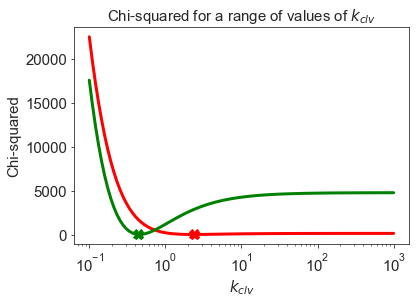

In [66]:
model_ID = 'Clv_Saturated_general_energies_v2+general_energies_no_kPR'; parnum = '44'

filename = 'fit_18_7_2019_sim_17.txt' #not rate limiting kclv, best fit
path = '../fits_Stijn/18_7_2019/'
data = pd.read_table(path+filename,index_col=False)
chi = data.loc[:,'Potential']
final_par = data.loc[np.argmin(chi),'Parameter 1':'Parameter '+parnum]
final_par_np = np.array(final_par.values)

model_ID = 'Clv_Saturated_general_energies_v2'

final_par_np = np.append(final_par_np[1:-3],final_par_np[-2:]) #getting the parameters relevant for cleavage

parameters = final_par_np.copy()
kclv = np.logspace(-1.,3.,100)

chi1 = []
chi_weights = [1.,1./20.,1./190.]

for i in kclv:
    parameters[-1] = np.log10(i)
    
    chitemp = 0.
    for j in range(len(xdata)):
        chitemp += clv.calc_chi_squared(parameters,xdata[j],ydatalog[j][0],yerrlog[j][0],chi_weights,False,False,False,20,model_ID)
    chi1.append(chitemp)

filename = 'fit_18_7_2019_sim_24.txt' #rate limiting kclv, best fit
path = '../fits_Stijn/18_7_2019/'
data = pd.read_table(path+filename,index_col=False)
chi = data.loc[:,'Potential']
T = data.loc[:,'Temperature']
final_par = data.loc[np.argmin(chi),'Parameter 1':'Parameter '+parnum]
final_par_np = np.array(final_par.values)

model_ID = 'Clv_Saturated_general_energies_v2'

final_par_np = np.append(final_par_np[1:-3],final_par_np[-2:]) #getting the parameters relevant for cleavage

parameters = final_par_np.copy()
kclv = np.logspace(-1.,3.,100)

chi2 = []
chi_weights = [1.,1./20.,1./190.]

for i in kclv:
    parameters[-1] = np.log10(i)
    
    chitemp = 0.
    for j in range(len(xdata)):
        chitemp += clv.calc_chi_squared(parameters,xdata[j],ydatalog[j][0],yerrlog[j][0],chi_weights,False,False,False,20,model_ID)
    chi2.append(chitemp)
    
plot1, = plt.plot(kclv,chi1,'r',linewidth=3.)
plt.semilogx(kclv[np.argmin(chi1)],chi1[np.argmin(chi1)],'rX',markersize=10)

plot2, = plt.plot(kclv,chi2,'g',linewidth=3.)
plt.semilogx(kclv[np.argmin(chi2)],chi2[np.argmin(chi2)],'gX',markersize=10)
plt.xlabel('$k_{clv}$',fontsize=15)
plt.ylabel('Chi-squared',fontsize=15)
plt.title('Chi-squared for a range of values of $k_{clv}$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

print chi1[np.argmin(chi1)]
print chi2[np.argmin(chi2)]

## For engineered proteins (chapter 6), see Engineered_proteins/Visualise_results_engineered.ipynb

## For sequence dependent models (chapter 7), see Sequence_dependent_model/visualise_results.ipynb